In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import cv2

from matplotlib import pyplot as plt

In [15]:
def load(train_fn: str,
         test_fn: str):
    train_df = pd.read_csv(train_fn)
    test_df = pd.read_csv(test_fn)

    X_train = np.array([[int(x) for x in s.split(',')] for s in train_df['Image']])
    y_train = np.array([int(s) for s in train_df['Category']])

    X_test = np.array([[int(x) for x in s.split(',')] for s in test_df['Image']])

    return (X_train, y_train), X_test


def train(X_train: np.array,
          y_train: np.array):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    # FREEZE: n_estimators=200, max_depth=None
    clf = RandomForestClassifier(n_estimators=200, max_depth=None)
    clf = clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    acc = metrics.accuracy_score(y_val, y_pred)
    print('Accuracy: {}'.format(acc))

    return clf, acc


def predict(clf,
            X_test: np.array,
            output_fn: str):
    y_pred = clf.predict(X_test)
    test_df = pd.DataFrame(data={'Category': y_pred})
    test_df.to_csv(output_fn, index_label='Id')
    return y_pred

In [4]:
# FREEZE: preprocess_image_v1

# gauss + tres + morphology + deskew -> not binary
# best on kaggle
def preprocess_image_v1(pixels):
    pixels = pixels.reshape(28, 28)
    blur = cv2.GaussianBlur(pixels.astype(np.float32), (3,3), 0)
    binary = cv2.threshold(blur.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = np.ones(shape=(2,2), dtype=np.uint8)
    pixels = cv2.morphologyEx(binary.astype(np.float32), cv2.MORPH_OPEN, kernel, iterations=1)
    return deskew(pixels)

# gauss + tres + morphology + deskew + again tres -> binary 
def preprocess_image_v2(pixels):
    pixels = pixels.reshape(28, 28)
    blur = cv2.GaussianBlur(pixels.astype(np.float32), (3,3), 0)
    binary = cv2.threshold(blur.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = np.ones(shape=(2,2), dtype=np.uint8)
    pixels = cv2.morphologyEx(binary.astype(np.float32), cv2.MORPH_OPEN, kernel, iterations=1)
    pixels = deskew(pixels).reshape(28, 28)
#     binary = cv2.threshold(pixels.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # Kaggle: +0.2% acc
    binary = cv2.threshold(pixels.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)[1]
    return binary.reshape(28 * 28)

def deskew(pixels):
    SZ = 28
    pixels = pixels.reshape(28, 28).astype(np.uint8)
    m = cv2.moments(pixels)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed. 
        return pixels.copy().reshape(28*28)
    # Calculate skew based on central momemts. 
    skew = m['mu11']/m['mu02']
    # Calculate affine transform to correct skewness. 
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    # Apply affine transform
    pixels = cv2.warpAffine(pixels, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LANCZOS4)
    return pixels.reshape(28 * 28)

In [6]:
def hog_feature(pixels):
    winSize = (28,28)
    blockSize = (14,14)
    blockStride = (7,7)
    cellSize = (7,7)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    useSignedGradients = True
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, useSignedGradients)
    return hog.compute(pixels.reshape(28,28)).reshape(-1)

In [7]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(2 * h, 2 * w))
    for i in range(h * w):
        plt.subplot(h, w, i+1)
        image = ds[idxs[i]].reshape(28,28)
        plt.imshow(image, cmap='gray')
        plt.title(labels[idxs[i]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [8]:
(X_train, y_train), X_test = load(
        train_fn='train.csv',
        test_fn='test.csv')

In [9]:
X_v1_train = np.apply_along_axis(preprocess_image_v1, axis=1, arr=X_train)
X_v1_test = np.apply_along_axis(preprocess_image_v1, axis=1, arr=X_test)

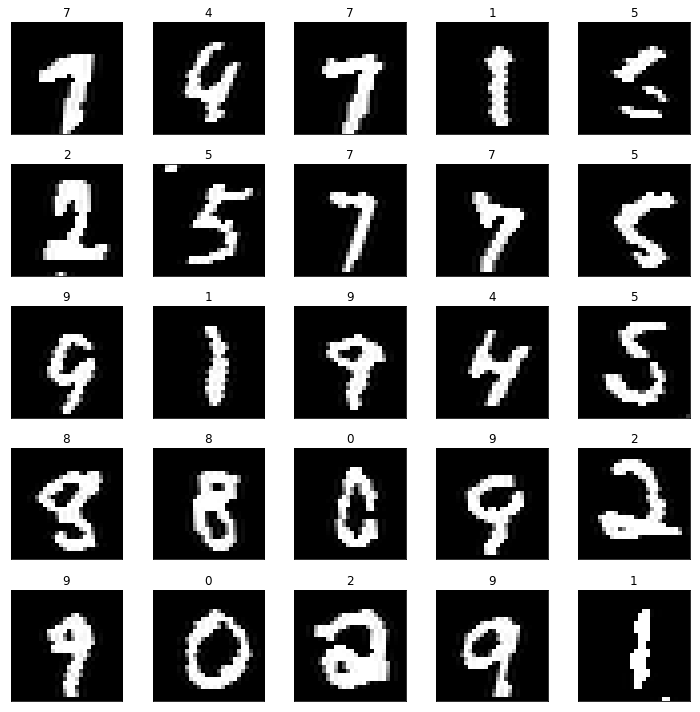

In [10]:
show_random_images(X_v1_train, y_train, 5, 5)

In [11]:
X_v1_train_hog = np.apply_along_axis(hog_feature, axis=1, arr=X_v1_train)
X_v1_test_hog = np.apply_along_axis(hog_feature, axis=1, arr=X_v1_test)

In [12]:
print(X_v1_train_hog.shape, X_v1_test_hog.shape)

(60000, 324) (10000, 324)


In [16]:
model, acc = train(X_v1_train_hog, y_train)
# test_pred = predict(model, X_v1_test_hog, 'submissions/submission_10_%0.5f.csv' % acc)

Accuracy: 0.9715833333333334


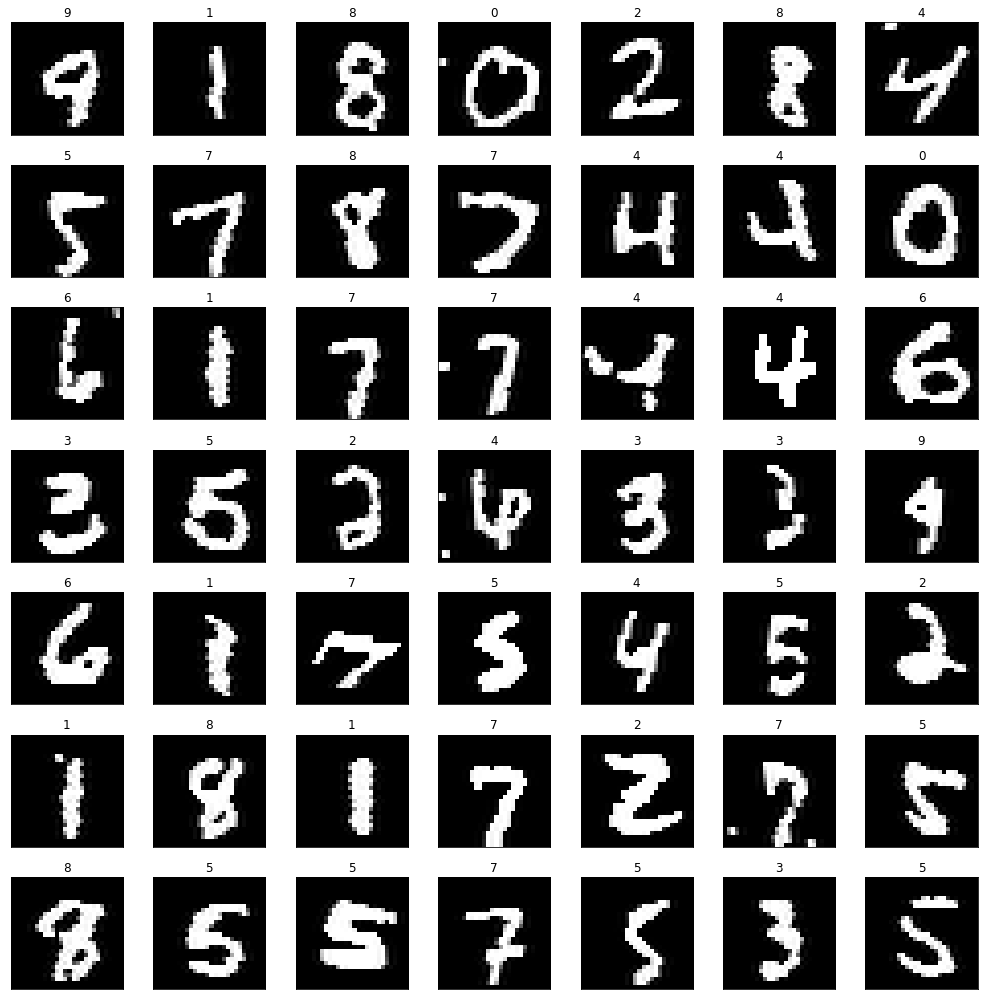

In [14]:
show_random_images(X_v1_test, test_pred, 7, 7)

In [16]:
# idx = np.random.randint(0, X_train.shape[0] - 1)
# image = X_v1_train[idx, :]
# hog = hog_feature(image)
# hog.shape

In [18]:
# idx = np.random.randint(0, X_train.shape[0] - 1)
# orig = X_train[idx, :].reshape(28, 28)
# v1 = X_v1_train[idx, :].reshape(28, 28)
# v2 = X_v2_train[idx, :].reshape(28, 28)

# label = y_train[idx]
# print_img(orig, v1, v2, label)

In [19]:
def print_img(image_1, image_2, image_3, label):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(image_1, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Before')
    
    plt.subplot(1, 3, 2)
    plt.imshow(image_2, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('After')

    plt.subplot(1, 3, 3)
    plt.imshow(image_3, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('After')
    
    plt.suptitle(label)
    plt.tight_layout()